## Experimenting with opencv

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

imagePath = "BCCD/JPEGImages"
csvPath = "BCCD/CSVAnnotations"

# red blood cells are red, platelets green, white blood cells are blue
colors = {'RBC': (255,0,0), 'Platelets': (0,255,0), 'WBC': (0,0,255)}

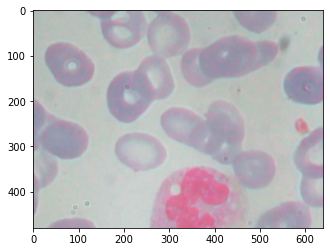

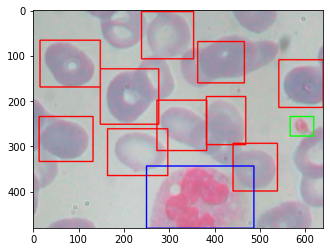

In [6]:
# Show example image and the objects
fileNum = "315"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1251


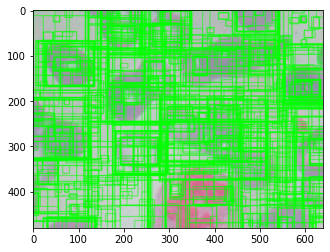

In [7]:
cv2.setUseOptimized(True);
# draw all bounding boxes produced by selective search
img = cv2.imread(os.path.join(imagePath, jpgFile))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imgOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imgOut)

In [8]:
# Calculate intersection/union ratio
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
IMG_SIZE = 224

In [10]:
# Create our training set from the proposed regions. For each image take at most MAXCOUNT each
# of positive and negative samples to make an even training set
MAXCOUNT = 25

labels = {'WBC': 3, 'RBC': 2, 'Platelets': 1, 'Background': 0}

train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for i, filename in enumerate(os.listdir(imagePath)):
    print(i, filename)
    csvName = filename.split(".")[0]+".csv"
    image = cv2.imread(os.path.join(imagePath, filename))
    objectsDf = pd.read_csv(os.path.join(csvPath, csvName))
    objects = []
    for idx, row in objectsDf.iterrows():
        filename, cell_type, xmin, xmax, ymin, ymax = row
        if xmin < xmax and ymin < ymax:
            objects.append({"x1": xmin, "x2": xmax, "y1": ymin, "y2": ymax, "label": cell_type})
        
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imgout = image.copy()
    
    trueCount = 0
    falseCount = 0
    for (x,y,w,h) in rects[:min(2000, len(rects))]:
        rect = {"x1": x, "x2": x+w, "y1": y, "y2": y+h}
        if trueCount < MAXCOUNT or falseCount < MAXCOUNT:
            for obj in objects:
                iou = get_iou(obj, rect)
                if trueCount < MAXCOUNT and iou > 0.7:
                    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(labels[obj['label']])
                    trueCount += 1

                if falseCount < MAXCOUNT and iou < 0.3:
                    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
                    falseCount += 1
        else:
            break

0 BloodImage_00315.jpg
1 BloodImage_00301.jpg
2 BloodImage_00117.jpg
3 BloodImage_00103.jpg


In [11]:
xTrain = np.array(train_images)
yTrain = np.array(train_labels)

In [12]:
print("Dataset shape: {}".format(xTrain.shape))
print("Label shape: {}".format(yTrain.shape))

Dataset shape: (191, 224, 224, 3)
Label shape: (191,)


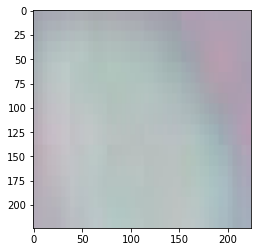

In [13]:
plt.imshow(xTrain[0])

## Training model

Referring to https://github.com/ByeongGil-Jung/Keras-CNN-RGB-Images/blob/master/src/d2_keras.ipynb

In [2]:
import keras

In [17]:
num_classes = 4
labels_one_hot = keras.utils.np_utils.to_categorical(yTrain, num_classes)

In [18]:
xTrain = xTrain.astype("float32")

In [19]:
xTrain /= 255.

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xTrain, labels_one_hot, test_size=0.1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [37]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2), padding="same"))

model.add(Conv2D(32, (5, 5), activation="relu", strides=(2,2), padding="same"))
model.add(MaxPooling2D(pool_size=(2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)       

In [39]:
# load previous weights
model.load_weights('weights.h5')

In [26]:
model.save("model", save_format='tf')

INFO:tensorflow:Assets written to: model/assets


In [48]:
epochs = 2

In [30]:
from tensorflow.keras import optimizers

batch_size = 128
lr = 0.001
decay = 1e-6

optimizer = optimizers.RMSprop(learning_rate=lr, decay=decay)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [50]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, validation_data=(x_test, y_test), 
    shuffle=True, 
    verbose=1
)

Train on 15340 samples, validate on 1705 samples
Epoch 1/2
15340/15340 [==============================] - 396s 26ms/step - loss: 0.3024 - accuracy: 0.9158 - val_loss: 0.1136 - val_accuracy: 0.9525
Epoch 2/2
15340/15340 [==============================] - 387s 25ms/step - loss: 0.1976 - accuracy: 0.9350 - val_loss: 0.0932 - val_accuracy: 0.9677


In [54]:
model.save_weights("./weights-2.h5")

In [58]:
y_pred = model.predict(xTrain[:10])
y_pred_label = np.argmax(y_pred, axis=1)

In [59]:
xTrain[:10].shape

(10, 224, 224, 3)

## Predicting

In [33]:
labelColors = {1: (0,255,0), 2: (255,0,0), 3: (0,0,255)}

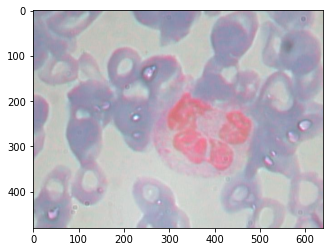

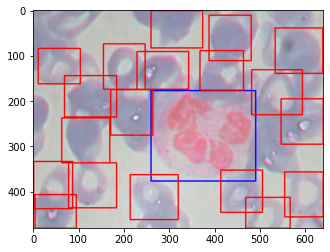

In [31]:
# Show example image and the objects
fileNum = "000"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1475
Total time: 94.999075ms. Pred time: 94.402075
Total time: 35.600185ms. Pred time: 35.249949
Total time: 38.427830ms. Pred time: 37.977934
Total time: 43.036938ms. Pred time: 42.697906
Total time: 42.356968ms. Pred time: 41.874170
Total time: 39.196014ms. Pred time: 38.800955
Total time: 39.401293ms. Pred time: 38.995266
Total time: 38.926840ms. Pred time: 38.538933
Total time: 37.335157ms. Pred time: 36.966085
Total time: 40.758133ms. Pred time: 40.339231
Total time: 38.958788ms. Pred time: 38.459778
Total time: 38.050890ms. Pred time: 37.648916
Total time: 37.962914ms. Pred time: 37.489176
Total time: 46.349049ms. Pred time: 45.997143
Total time: 39.376974ms. Pred time: 38.920164
Total time: 42.061806ms. Pred time: 41.430950
Total time: 38.964033ms. Pred time: 38.494110
Total time: 38.226843ms. Pred time: 37.837029
Total time: 37.704945ms. Pred time: 37.240744
Total time: 37.174940ms. Pred time: 36.782026
Total time: 36.976337ms. Pred time: 36.599159
Total time: 40.714979ms. Pred

Total time: 40.987015ms. Pred time: 40.652990
Total time: 38.805008ms. Pred time: 38.225889
Total time: 48.448086ms. Pred time: 47.241926
Total time: 38.135052ms. Pred time: 37.909031
Total time: 38.294077ms. Pred time: 37.866354
Total time: 37.316799ms. Pred time: 36.876917
Total time: 43.743849ms. Pred time: 42.964935
Total time: 38.369656ms. Pred time: 37.878036
Total time: 38.088083ms. Pred time: 37.602186
Total time: 37.636995ms. Pred time: 37.248135
Total time: 37.588120ms. Pred time: 37.225962
Total time: 37.577868ms. Pred time: 37.169933
Total time: 51.692963ms. Pred time: 51.351070
Total time: 39.735794ms. Pred time: 39.220810
Total time: 39.644957ms. Pred time: 39.230108
Total time: 35.276890ms. Pred time: 34.895897
Total time: 36.722898ms. Pred time: 36.264896
Total time: 36.782026ms. Pred time: 36.430120
Total time: 42.459249ms. Pred time: 42.119265
Total time: 40.895939ms. Pred time: 40.351868
Total time: 38.199663ms. Pred time: 37.906885
Total time: 38.660288ms. Pred time

Total time: 52.022934ms. Pred time: 51.578999
Total time: 50.402641ms. Pred time: 49.808741
Total time: 47.420025ms. Pred time: 47.003984
Total time: 54.496050ms. Pred time: 53.989172
Total time: 40.358782ms. Pred time: 39.864063
Total time: 42.374134ms. Pred time: 41.998148
Total time: 39.448023ms. Pred time: 38.957119
Total time: 37.627935ms. Pred time: 37.249088
Total time: 37.012100ms. Pred time: 36.616325
Total time: 36.416054ms. Pred time: 35.963058
Total time: 37.938833ms. Pred time: 37.587881
Total time: 41.473150ms. Pred time: 41.068077
Total time: 40.040970ms. Pred time: 39.468050
Total time: 47.225237ms. Pred time: 46.817064
Total time: 37.774086ms. Pred time: 37.383080
Total time: 37.187099ms. Pred time: 36.711216
Total time: 36.722183ms. Pred time: 36.365986
Total time: 42.117119ms. Pred time: 41.766167
Total time: 38.732052ms. Pred time: 38.213968
Total time: 38.311958ms. Pred time: 37.906885
Total time: 38.226843ms. Pred time: 37.840843
Total time: 37.978888ms. Pred time

Total time: 36.837816ms. Pred time: 36.490917
Total time: 37.039042ms. Pred time: 36.372900
Total time: 43.450117ms. Pred time: 42.968035
Total time: 44.604063ms. Pred time: 44.067144
Total time: 38.053751ms. Pred time: 37.706852
Total time: 37.297964ms. Pred time: 36.837101
Total time: 38.422108ms. Pred time: 37.971973
Total time: 36.503077ms. Pred time: 36.148071
Total time: 35.513878ms. Pred time: 35.170078
Total time: 36.332130ms. Pred time: 35.989046
Total time: 36.030769ms. Pred time: 35.674810
Total time: 36.834955ms. Pred time: 36.492109
Total time: 36.564827ms. Pred time: 36.094904
Total time: 42.684078ms. Pred time: 42.330980
Total time: 35.164833ms. Pred time: 34.816980
Total time: 35.635948ms. Pred time: 35.294056
Total time: 37.293196ms. Pred time: 36.942244
Total time: 38.096905ms. Pred time: 37.755728
Total time: 35.972118ms. Pred time: 35.509109
Total time: 39.712906ms. Pred time: 39.361954
Total time: 37.408829ms. Pred time: 36.948919
Total time: 37.376881ms. Pred time

Total time: 42.522907ms. Pred time: 41.805744
Total time: 38.973808ms. Pred time: 38.443804
Total time: 39.090872ms. Pred time: 38.660049
Total time: 50.782919ms. Pred time: 50.492048
Total time: 42.376995ms. Pred time: 41.934967
Total time: 45.465946ms. Pred time: 45.023918
Total time: 43.655157ms. Pred time: 43.143034
Total time: 43.821812ms. Pred time: 43.383837
Total time: 40.674210ms. Pred time: 40.243149
Total time: 38.461208ms. Pred time: 38.053274
Total time: 38.979769ms. Pred time: 38.579941
Total time: 40.181875ms. Pred time: 39.687872
Total time: 38.985968ms. Pred time: 38.573742
Total time: 49.050093ms. Pred time: 48.633099
Total time: 39.598227ms. Pred time: 39.217234
Total time: 38.234949ms. Pred time: 37.836075
Total time: 40.673018ms. Pred time: 40.220261
Total time: 39.297104ms. Pred time: 38.868904
Total time: 38.441896ms. Pred time: 38.043976
Total time: 38.548946ms. Pred time: 38.144112
Total time: 37.822962ms. Pred time: 37.413120
Total time: 40.894985ms. Pred time

Total time: 42.891979ms. Pred time: 42.441130
Total time: 39.674997ms. Pred time: 39.170265
Total time: 38.790226ms. Pred time: 38.369179
Total time: 48.387051ms. Pred time: 48.012018
Total time: 39.441109ms. Pred time: 38.968086
Total time: 39.490700ms. Pred time: 39.097786
Total time: 41.358709ms. Pred time: 40.883780
Total time: 39.388895ms. Pred time: 38.972855
Total time: 39.165974ms. Pred time: 38.680792
Total time: 38.674831ms. Pred time: 38.281918
Total time: 38.984060ms. Pred time: 38.509130
Total time: 42.873144ms. Pred time: 42.433977
Total time: 39.034843ms. Pred time: 38.534880
Total time: 47.423124ms. Pred time: 47.001123
Total time: 38.732767ms. Pred time: 38.262606
Total time: 38.540125ms. Pred time: 38.072109
Total time: 39.090157ms. Pred time: 38.675308
Total time: 41.915894ms. Pred time: 41.348934
Total time: 39.370060ms. Pred time: 38.796186
Total time: 38.523912ms. Pred time: 38.152933
Total time: 39.282084ms. Pred time: 38.890839
Total time: 38.805962ms. Pred time

Total time: 43.553114ms. Pred time: 43.165922
Total time: 42.706966ms. Pred time: 42.191267
Total time: 42.434216ms. Pred time: 42.007208
Total time: 54.548979ms. Pred time: 54.137707
Total time: 44.275999ms. Pred time: 43.833017
Total time: 45.620918ms. Pred time: 45.146227
Total time: 41.576862ms. Pred time: 41.014671
Total time: 40.097713ms. Pred time: 39.682865
Total time: 39.324045ms. Pred time: 38.900137
Total time: 38.951874ms. Pred time: 38.579941
Total time: 38.357019ms. Pred time: 37.937164
Total time: 42.967081ms. Pred time: 42.546034
Total time: 39.424896ms. Pred time: 38.935900
Total time: 48.712969ms. Pred time: 48.297167
Total time: 39.315939ms. Pred time: 38.872719
Total time: 38.951874ms. Pred time: 38.543701
Total time: 39.376259ms. Pred time: 38.928270
Total time: 41.561127ms. Pred time: 41.093826
Total time: 39.710999ms. Pred time: 39.266825
Total time: 38.931847ms. Pred time: 38.545847
Total time: 38.651943ms. Pred time: 38.178921
Total time: 38.846970ms. Pred time

Total time: 41.265965ms. Pred time: 40.859938
Total time: 50.321817ms. Pred time: 49.762011
Total time: 39.328098ms. Pred time: 38.902044
Total time: 38.885832ms. Pred time: 38.464069
Total time: 37.606955ms. Pred time: 37.281990
Total time: 38.109064ms. Pred time: 37.763119
Total time: 43.556929ms. Pred time: 43.073893
Total time: 40.391922ms. Pred time: 39.950132
Total time: 39.017916ms. Pred time: 38.645983
Total time: 38.106203ms. Pred time: 37.697077
Total time: 37.703276ms. Pred time: 37.366152
Total time: 51.234961ms. Pred time: 50.896883
Total time: 39.122105ms. Pred time: 38.527966
Total time: 38.565159ms. Pred time: 38.181067
Total time: 39.826870ms. Pred time: 38.718939
Total time: 38.360834ms. Pred time: 37.966967
Total time: 37.630081ms. Pred time: 37.266016
Total time: 43.528795ms. Pred time: 43.100834
Total time: 40.417910ms. Pred time: 39.853811
Total time: 40.020943ms. Pred time: 38.938046
Total time: 39.217949ms. Pred time: 38.817883
Total time: 47.319651ms. Pred time

Total time: 43.181658ms. Pred time: 42.218924
Total time: 46.414852ms. Pred time: 45.912027
Total time: 43.310881ms. Pred time: 41.684151
Total time: 43.199062ms. Pred time: 42.784929
Total time: 40.805817ms. Pred time: 40.298939
Total time: 40.169954ms. Pred time: 39.822817
Total time: 41.100979ms. Pred time: 40.820837
Total time: 39.156914ms. Pred time: 38.689852
Total time: 38.767815ms. Pred time: 38.404942
Total time: 47.623873ms. Pred time: 47.196150
Total time: 39.314270ms. Pred time: 39.077044
Total time: 41.026115ms. Pred time: 40.026188
Total time: 39.249897ms. Pred time: 38.082123
Total time: 38.717985ms. Pred time: 38.322926
Total time: 39.778709ms. Pred time: 38.327694
Total time: 38.249016ms. Pred time: 37.914038
Total time: 39.625168ms. Pred time: 39.296865
Total time: 39.201021ms. Pred time: 38.671017
Total time: 38.275957ms. Pred time: 38.025856
Total time: 47.922850ms. Pred time: 46.812057
Total time: 39.202690ms. Pred time: 38.807869
Total time: 38.913250ms. Pred time

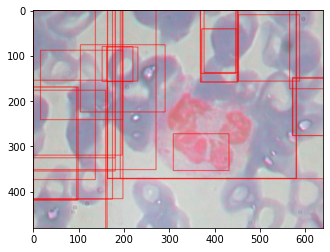

In [40]:
import time
img = cv2.imread(os.path.join(imagePath, jpgFile))

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
count = 0
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    a = time.time()
    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA).astype('float32')
    resized /= 255. 
    resized = np.expand_dims(resized, axis=0)
    b = time.time()
    pred = model.predict(resized)
    label = (np.argmax(pred, axis=1)[0])
    c = time.time()
    print(f'Total time: {1000*(c-a):2f}ms. Pred time: {1000*(c-b):2f}')
    if label > 0 and pred[0][label] >= 0.9999:
        count += 1
        cv2.rectangle(imgOut, (x, y), (x+w, y+h), labelColors[label], 1, cv2.LINE_AA)
plt.imshow(imgOut)
print(count)